In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds

# Import Data

Input data includes:
- User Info (sex, income)
- Item Info (BOW, TF-IDF)
- User-Item Interaction
    - active/explicit: rating
    - passive/implicit: clickstream analysis


Input data dimension
- Can be million+ user
- Can be 10k+ products

Load example data

In [9]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/ml-100k/u.data', sep='\t', names=header)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


# Content-basd Recommendation

- Calculate **similarity** between **items** of **ONE user**
- Similarity is calculated based on item attribute (for example, location, price, cuisine, etc.)
    - Output: An item space with defined distance
- One model for one user; No interaction between users

# Memory-based CF

In [11]:
df_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    df_matrix[line[1]-1, line[2]-1] = line[3]
df_matrix.shape

(943, 1682)

## Define Cosine Similarity
$Similarity = cos(\theta) = \frac{\mathbf A \cdot \mathbf B }{||\mathbf A|| \ ||\mathbf B|| }$

In [14]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(df_matrix, metric='cosine')
user_similarity.shape

(943, 943)

In [16]:
item_similarity = pairwise_distances(df_matrix.T, metric='cosine')
item_similarity.shape

(1682, 1682)

## Evaluation metrics

- Rating prediction: RMSE, MAE
- Top-k rating precision: Recall, AUC
    - % of the top-k recommendations that were actually used by user
- Possible benchmark model: global top-k recommendations

## Prediction

### User-Item Filtering
- Users who are similar to you also liked ...
- Prediction for user **k** for movie **m** :

- Prediction = User **k** bias + adjustmemnt from similar user
    - $ \hat{x}_{k,m} = \bar x_k + \frac{\Delta}{Norm}  $


- Adjustment = (similarity with another user) * (rating of another user - bias of another user)
    - $ \Delta = \sum_{k_0}UserSim(k, k_0) \cdot (x_{k_0, m} - \bar x_{k0})$

    - $ Norm = \sum_{k_0}|UserSim(k, k_0)|$


In [43]:
def ui_predict(ratings, similarity):
    all_user_mean = ratings.mean(axis = 1)
    ratings_diff = (ratings - all_user_mean[:, np.newaxis]) # (943, 1682)
    
    adjust = similarity.dot(ratings_diff)
    norm = np.array([np.abs(similarity).sum(axis=1)]).T

    pred = all_user_mean[:, np.newaxis] + adjust / norm
    
    return pred

In [36]:
ui_predict(df_matrix, user_similarity).shape

(943, 1682)

### Item-Item Filtering
Users who liked this item also liked ...

   - $ \hat{x}_{k,m} = \sum_{m_0}ItemSim(m, m_0) \cdot x_{k, m_0} / Norm$

In [40]:
def ii_predict(ratings, similarity):
    norm = np.array([np.abs(similarity).sum(axis=1)])
    pred = ratings.dot(similarity)  / norm
    return pred

In [42]:
ii_predict(df_matrix, item_similarity).shape

(943, 1682)

# Model-Based CF 

## Matrix Factorization
Singular-Value-Decomposition

<img src="https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/figures/BLOG_CCA_4.png" width="400">


- $M = U \times \Sigma \times V^T  $ Note: $\Sigma$ can be multipled to U or V
- Con: need default value for missing value in rating matrix
- U and V are low-dimention latent vectors (**Embeddings**) for users and movies. 


- Alternative approach: $Min(L) = \sum_{i,j}{(u_i v_j - x_{ij})^2}$; solved by SGD

In [52]:
u, s, vt = svds(df_matrix, k = 20)
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

<img src="https://cdn-images-1.medium.com/max/1760/1*2i-GJO7JX0Yz6498jUvhEg.png" width="600">


## Other methods: 
- Probabilistic factorization (PMF)
    * P = dot_product(i,j) + User_i_bias + movie_j_bias + intercept
- Non-negative factorization (NMF)

## Hybrid

- Weighted rankings from two models
- Cascade: 1) Accurate model -> rough rank; 2) 2nd one to refine
- Treat collaborative factors as extra feature for content-based model

# Model-Based CF - Deep Learning

- Main difference with SVD
    - Don't require orthogonal vectors as in SVD
    - Learn the embedding by itself
    - Allows non-linearity instead of just dot product
    
- Extra benefits
    - Can incoporate additional features like user profile
    

## Model Types

### Basic Idea V1
- One-hot encoding for user i
- Hiddern layer: Embedding layer for users
    - Weights: latent vector for users
    
    
- Output layer: output ratings for each item j
    - Weights: latent vector for movies
    
    
###  Basic Idea V2
- One-hot encoding for user i
- Hiddern layer: Embedding layer for users
    - Weights: latent vector for users
    
    
- One-hot encoding for item j
- Hidden layer: output ratings for each movie j
    - Weights: latent vector for movies


- More hidden layers

<img src="https://image.slidesharecdn.com/neuralcollaborativefiltering-170528094418/95/neural-collaborative-filtering-9-638.jpg?cb=1496201763" width="600">
    

###  A lot of other DL network types    

Example: https://arxiv.org/abs/1708.05031
<img src="https://nipunbatra.github.io/blog/2017/neumf.png" width="600">



## Example in Keras

In [54]:
import keras
from IPython.display import SVG
from keras import Model
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense, Dropout
from keras.utils.vis_utils import model_to_dot

### Model Params

In [55]:
n_latent_factors = 20

### Define Model

In [56]:
item_input = Input(shape = [1], name = 'Item-input')
item_embedding = Embedding(n_items, n_latent_factors, name = 'Item-embedding')(item_input)
item_flat = Flatten(name = 'Item-flatten')(item_embedding)

In [57]:
user_input = Input(shape = [1], name = 'User-input')
user_embedding = Embedding(n_users, n_latent_factors, name = 'User-embedding')(user_input)
user_flat = Flatten(name = 'User-flatten')(user_embedding)

**Option1**

In [58]:
dotprod = Dot(axes=1, name='DotProduct')([item_flat, user_flat])
model = Model([item_input, user_input ], dotprod)
model.compile('adam', 'mean_squared_error')

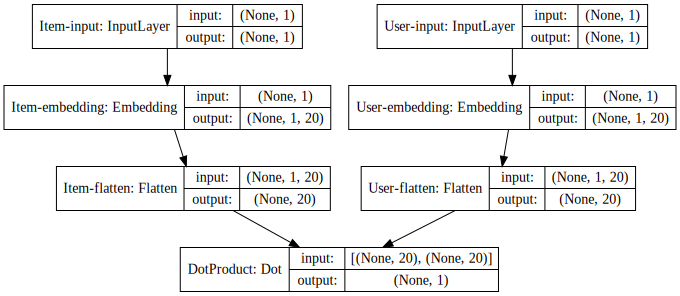

In [59]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

**Option2**

In [63]:
concatenate = Concatenate(name='Concatenate')([item_flat, user_flat])
dropout = Dropout(0.2,name='Dropout')(concatenate)
dense_1 = Dense(20,activation='relu', name='FC-1')(dropout)
activation = Dense(1, activation='relu', name='Activation')(dense_1)
model = Model([item_input, user_input ], activation)
model.compile('adam', 'mean_squared_error')

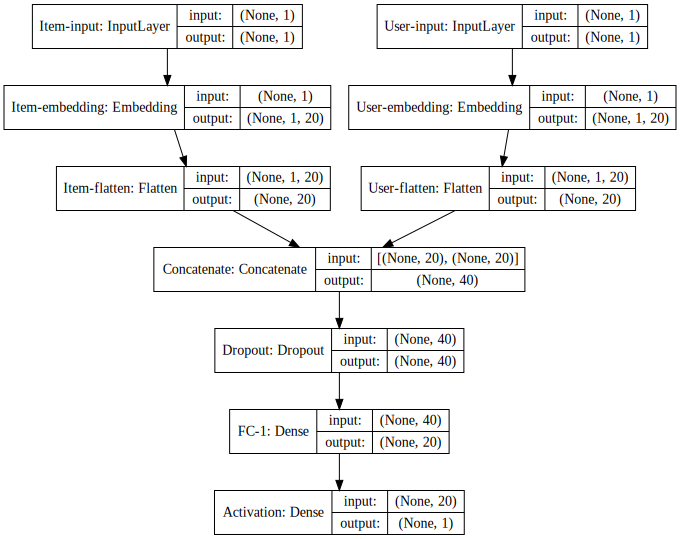

In [64]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

### Model Training

In [65]:
#https://keras.io/models/model/
model.fit(x = [df.item_id - 1, df.user_id - 1], 
          y = df.rating, 
          epochs = 15, 
          verbose = 2, 
          validation_split = 0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/15
 - 4s - loss: 1.5278 - val_loss: 0.9136
Epoch 2/15
 - 3s - loss: 0.9126 - val_loss: 0.8956
Epoch 3/15
 - 3s - loss: 0.8964 - val_loss: 0.8882
Epoch 4/15
 - 3s - loss: 0.8809 - val_loss: 0.8799
Epoch 5/15
 - 3s - loss: 0.8614 - val_loss: 0.8652
Epoch 6/15
 - 3s - loss: 0.8486 - val_loss: 0.8639
Epoch 7/15
 - 3s - loss: 0.8381 - val_loss: 0.8644
Epoch 8/15
 - 3s - loss: 0.8255 - val_loss: 0.8608
Epoch 9/15
 - 3s - loss: 0.8156 - val_loss: 0.8549
Epoch 10/15
 - 3s - loss: 0.8033 - val_loss: 0.8568
Epoch 11/15
 - 3s - loss: 0.7958 - val_loss: 0.8511
Epoch 12/15
 - 3s - loss: 0.7857 - val_loss: 0.8489
Epoch 13/15
 - 3s - loss: 0.7771 - val_loss: 0.8513
Epoch 14/15
 - 3s - loss: 0.7703 - val_loss: 0.8451
Epoch 15/15
 - 3s - loss: 0.7656 - val_loss: 0.8548


### Extract Weight

In [66]:
model.get_layer(name='User-embedding').get_weights()[0].shape

(943, 20)

In [67]:
model.get_layer(name='Item-embedding').get_weights()[0].shape

(1682, 20)

# Possible A/B Test

https://medium.com/nikeengineering/serving-athletes-with-personalized-workout-recommendations-285491eabc3d

- Group: 
50 percent baseline as the Champion 
50 percent Collaborative Filtering 

- KPI: 
User actually start a workout that shown from a recommended section


# Reference
- https://arxiv.org/pdf/1606.07792.pdf
- https://www.slideshare.net/kerveros99/deep-learning-for-recommender-systems-recsys2017-tutorial?from_action=save